# <span style='font-family:Helvetica;font-size:20pt;color:DarkCyan;font-weight:bold'>Deep Convolutional Generative Adversarial Networks for non Computer Scientists:</span>
---

Deep Convolutional Generative Adversarial Networks, or DCGANs for short, is a particular kind of GANs proposed by [Radford](https://www.linkedin.com/in/alecradford/) et al. in the paper ["Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks" (2016)](https://arxiv.org/abs/1511.06434). They discovered that with DCGANs it is possible to make both Generator (G) and the Discriminator (D) learn a hierarchy of representations from object parts to scenes.

The crucial points of the paper are:
1. Don't use pooling but let the network learn its own spatial downsampling with strided convolution;
2. Use Batch Normalization (BN) in both G and D;
3. Remove fully connected layers on top of convolutional features;
4. Use ReLU activation in generator for all layers except for the output, which uses Tanh;
5. Use LeakyReLU activation in the discriminator for all layers

The final architecture will be not so different from the one in the previous notebook about Vanilla Gans, except from the fact that now we will use Convolutional and Transposed Convolutional layers. Below the picture of the Generator architecture from the original paper:

<img src="../images/dcgans.png" width=800 height=600 />

## Code

As usual we will start by importing the required libraries.

In [1]:
import os
import zipfile
import time
import enum
import shutil

import imageio

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

from tqdm.auto import tqdm

import torch
from torch import nn
from torch.optim import Adam
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from torch.hub import download_url_to_file

Let's connect our notebook with Colab:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Check if CUDA is avaliable:

In [3]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  cuda = True
else:
  device = torch.device("cpu")
  cuda = False
print(f'Working with GPU: {cuda}')

Working with GPU: True


Now we should store some useful path to our Drive and create the required folders:

In [4]:
# Current model
MODEL = 'dcgan'
# Path to the project folder
DRIVE_MAIN_DIR_PATH = os.path.join(os.getcwd(), 'drive/My Drive/Colab Notebooks/GANs')
# Path to the data set
DATA_DIR_PATH = os.path.join(DRIVE_MAIN_DIR_PATH, 'data/CelebA')
os.makedirs(DATA_DIR_PATH, exist_ok=True)
# Path to the images
IMG_DIR_PATH = os.path.join(DRIVE_MAIN_DIR_PATH, 'images/models/' + MODEL)
os.makedirs(IMG_DIR_PATH, exist_ok=True)
# Path to the weights
WEIGHTS_DIR_PATH = os.path.join(DRIVE_MAIN_DIR_PATH, 'weights/' + MODEL)
os.makedirs(WEIGHTS_DIR_PATH, exist_ok=True)

## Model

Differently from the notebook on the Vanilla GANs, here we will work with coloured images. The difference between grayscale and RGB images is that, considering images with $64$ pixels in each dimensions, in the first case the dimension of each sample is $1 \times 64 \times 64$, while in the RGB case is $3 \times 64 \times 64$.

Another important aspect which should be considered is how the network transform the noise vector into an image. The noise is generated in the exactly the same way and than it is passed to the so called _Project and Reshape layers_. This layer is a simple `Linear` layer in which we want the output to be a $4 \times 4$ (width $\times$ height) with $1024$ channels. To achieve this we will expand our $100-$Dimensional noise into a $1024 \times 4 \times 4 -$Dimensional space and then we will reshape it to the desired dimension.

In order to increase the number of pixels in each layer we will use the layer [`ConvTranspose2d`](https://pytorch.org/docs/master/generated/torch.nn.ConvTranspose2d.html). Basically, it performs the opposite of the a standard `Conv2d` layer. I suggest you to read this very nice [post](https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215) about convolutions.

Let's start by defining the function to generate the noise:

In [5]:
def generate_noise(num_samples, latent_dim):
    """ Noise generator for the input of the generator network.

    Args:
        num_samples (int): number of samples in the current batch;
        latent_dim (int): dimension of the latent space
    Returns:
        z (Tensor): a Tensor containing a noise vector for each samples
    """
    z = torch.randn((num_samples, latent_dim)).to(device)
    return z

From the documentation of PyTorch, the shape of the input of a convolutional layer is:

$$ (\text N,  \text C_{in}, \text H, \text W) $$

where $ \text N $ is the batch size, $ \text C_{in}$ is the number of channels relative to the colour of the image, $ \text H $ is the height and $ \text W $the width.

Let's define the __Generator__:

In [7]:
# Dimension of the latent space
latent_dim = 100
# Channels in each layer of the generator
channels_g = (1024, 512, 256, 128, 3)
# All Transposed convolution will have the same parameters
kernel_size = 4
stride = 2
padding = 1

class Generator(nn.Module):
    """  Generator class: a class to instantiate the generator network and to
    implement its forward pass.

    Args:
        latent_dim (int): dimension of the latent vector;
        channels (tuple): tuple with number of channels for each layer
        kernel_size (int): dimension of the transposed convolution kernel
        stride (int): dimension of the transposed convolution stride
        padding (int): amount of the transposed convolution padding
    """

    def __init__(self, latent_dim, channels, kernel_size, stride, padding):
        super(Generator, self).__init__()
        self.channels = channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        def generator_block(in_channels, out_channels, last=False, bias=False):
            """ Function to generate a block of layers for the generator
            network of DCGANs

            Args:
                in_channels (int): number of channels in input;
                out_channels (int): number of channels in output
                last (boolean): True or False if last layer
                bias (boolean): True or False if bias present

            Returns:
                layers (list): a list containing a block of layers
            """
            layers = [nn.ConvTranspose2d(in_channels=in_channels,
                                         out_channels=out_channels,
                                         kernel_size=self.kernel_size,
                                         stride=self.stride, 
                                         padding=self.padding,
                                         bias=bias)]
            if not last:
                layers.append(nn.BatchNorm2d(num_features=out_channels))
                layers.append(nn.ReLU(inplace=True))
            else:
                layers.append(nn.Tanh())

            return layers
        
        # Project and reshape noise vector
        self.projector = nn.Linear(latent_dim, self.channels[0] * 4 * 4)
        # Define the architecture
        self.model = nn.Sequential(
            # Unpacking lists of layers
            *generator_block(self.channels[0], self.channels[1]),
            *generator_block(self.channels[1], self.channels[2]),
            *generator_block(self.channels[2], self.channels[3]),
            # Final layer
            *generator_block(self.channels[3], self.channels[-1], last=True)
        )

    def forward(self, z):
        """ Forward pass for the generator network.

        Args:
            z (Tensor): a noise tensor with dimensions 
            (n_samples, latent_dim, 1, 1)

        Returns:
            fake_image (Tensor): a fake image with dimension 
            (n_samples, color_channels, (image_dim)).
        """
        z_projected = self.projector(z)
        z_projected_reshaped = z_projected.view(z_projected.shape[0],
                                                self.channels[0], 4, 4)
        fake_image = self.model(z_projected_reshaped)
        return fake_image

From the summary of the Generator below you can see that the channels of each layer is exactly the same of the picture of the original paper.

In [8]:
# Print Generator summary
generator = Generator(latent_dim=latent_dim, channels=channels_g,
                      kernel_size=kernel_size, stride=stride,
                      padding=padding).to(device)
print(generator)

Generator(
  (projector): Linear(in_features=100, out_features=16384, bias=True)
  (model): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [9]:
# Test generator with noise
z = generate_noise(10, latent_dim)
generator(z).shape

torch.Size([10, 3, 64, 64])

Let's now define the __Discriminator__:

In [11]:
# Channels in each layer of the discriminator
channels_d = (3, 128, 256, 512, 1024, 1)

class Discriminator(nn.Module):
    """  Discriminator class: a class to instantiate the discriminator network 
    and to implement its forward pass.

    Args:
        channels (tuple): tuple with number of channels for each layer
        kernel_size (int): dimension of the transposed convolution kernel
        stride (int): dimension of the transposed convolution stride
        padding (int): amount of the transposed convolution padding
    """

    def __init__(self, channels, kernel_size, stride, padding):
        super(Discriminator, self).__init__()
        self.channels = channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        def discriminator_block(in_channels, out_channels, bias=False,
                                first=False, last=False):
            """ Function to generate a block of layers for the discriminator
            network of DCGANs

            Args:
                in_channels (int): number of channels in input;
                out_channels (int): number of channels in output;
                first (boolean): True or False if first layer;
                last (boolean): True or False if last layer;
                bias (boolean): True or False if bias present

            Returns:
                layers (list): a list containing a block of layers
            """
            padding = self.padding if not last else 0
            layers = [nn.Conv2d(in_channels=in_channels,
                                out_channels=out_channels,
                                kernel_size=self.kernel_size, 
                                stride=self.stride, padding=padding,
                                bias=bias)]
            if not first and not last:
                layers.append(nn.BatchNorm2d(out_channels))
            if not last:
                layers.append(nn.LeakyReLU(0.2, inplace=True))
            else:
                layers.append(nn.Sigmoid())
            return layers

        # Define the architecture
        self.model = nn.Sequential(
            # First layer
            *discriminator_block(self.channels[0], self.channels[1], first=True),
            *discriminator_block(self.channels[1], self.channels[2]),
            *discriminator_block(self.channels[2], self.channels[3]),
            *discriminator_block(self.channels[3], self.channels[4]),
            # Last layer
            *discriminator_block(self.channels[4], self.channels[-1], last=True),
        )

    def forward(self, image):
        """ Forward pass for the discriminator network.

        Args:
            image (Tensor): an image tensor
        Returns:
            prediction (Tensor): a vector of 1s and 0s
        """
        prediction = self.model(image)
        return prediction

In [12]:
discriminator = Discriminator(channels=channels_d, kernel_size=kernel_size,
                              stride=stride, padding=padding).to(device)
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (12): Sigmoid()
  )
)


In [13]:
# Test discriminator with generator output
discriminator(generator(z)).shape

torch.Size([10, 1, 1, 1])

### CelebA data set

In this notebook we will play around with the [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset. This is a large-scale face attributes dataset with more than $200K$ celebrity images.

Let's start downloading it. Be aware that this step will be reaaaaally slow:

In [14]:
# If folder celeba does not exists, download data set
if not os.path.isdir(DATA_DIR_PATH + '/celeba'):
    celeba_url = r'https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip'
    download_url_to_file(celeba_url, DATA_DIR_PATH + '/CelebA.zip')

    with zipfile.ZipFile(DATA_DIR_PATH + '/CelebA.zip') as zf:
        zf.extractall(DATA_DIR_PATH)

    # Move folder inside CelebA folder
    shutil.move(DATA_DIR_PATH + '/processed_celeba_small/celeba', DATA_DIR_PATH)

    # Remove two useles folder
    shutil.rmtree(DATA_DIR_PATH + '/processed_celeba_small', ignore_errors=True)
    shutil.rmtree(DATA_DIR_PATH + '/__MACOSX', ignore_errors=True)

As usual we define the function to visualize our images:

In [15]:
def show_images(image_tensor, num_images=25, size=(7, 7), n_row=5):
    """Function for visualizing images from torch Tensor

    Args:
        image_tensor (Tensor): an image tensor;
        num_images (int): number of images to display
        size (tuple): dimension of the picture
        n_row (int): number of images per row
    """
    # Detach from gradient and move from GPU to CPU
    image_cpu = image_tensor.detach().cpu()
    image_grid = make_grid(image_cpu[:num_images], nrow=n_row, normalize=True)
    plt.figure(figsize=size)
    plt.imshow(image_grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

Now we will import the data set and apply to it some transformations. The function `transform.Compose` allows to combine together different transformations:
1. `Resize`: resize the images to $64 \times 64$;
2. `CenterCrop`: crops the images in the center;
3. `ToTensor`: convert the images to tensors;
4. `Normalize`: normalize according to $\hat x = \frac{x - mean}{std}$. The first tuple are mean values for each channels and the second the std.


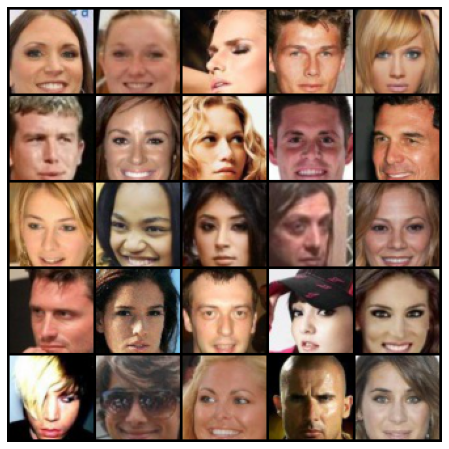

In [19]:
image_size = 64
batch_size = 128

# N.B. ImageFolder requires that the root contains subfolders,
# in which data is stored.
dataset = ImageFolder(root=DATA_DIR_PATH + '/',
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
celeba_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, drop_last=False)

# Plot some training images
real_batch = next(iter(celeba_dataloader))[0]
show_images(real_batch, size=(8,8))

### Training

The training process is exctly the same to the one for Vanilla GANs. In this case we will train for just $10$ epochs since the process requires a lot of time also on a GPU. However, we will obtain nice results even in few epochs.

In [20]:
adversarial_loss = nn.BCELoss()

epochs = 10

display_step = 50

latent_dim = 100

# Optimizer parameters from paper
learning_rate = 0.0002
beta_1 = 0.5
beta_2 = 0.999

# Instantiate models
generator = Generator(latent_dim=latent_dim, channels=channels_g,
                      kernel_size=kernel_size, stride=stride,
                      padding=padding).to(device)
discriminator = Discriminator(channels=channels_d, kernel_size=kernel_size,
                              stride=stride, padding=padding).to(device)

# Instantiate optimizers
generator_opt = torch.optim.Adam(generator.parameters(),
                                 lr=learning_rate, betas=(beta_1, beta_2))
discriminator_opt = torch.optim.Adam(discriminator.parameters(),
                                     lr=learning_rate, betas=(beta_1, beta_2))

Now we define how to compute the losses:

In [21]:
def get_discriminator_loss(generator, discriminator, adversarial_loss, real,
                           num_images, latent_dim):
    """ Compute Discriminator loss.

    Args:
        generator: generator network;
        discriminator: discriminator network;
        adversarial_loss: binary cross entropy loss;
        real (Tensor): real images;
        num_images (int): number of fake images to generate;
        latent_dim (int): dimension of the latent space
    Returns:
        discriminator_loss: loss of the discriminator network
    """
    # Generate noise from latent space
    random_input = generate_noise(num_images, latent_dim)
    # Generate images
    generated_images = generator(random_input)
    # Discriminator prediction on fake images. We use detach since 
    # here we are computing the loss of the Discriminator
    pred_D_fake = discriminator(generated_images.detach())
    # Loss on fake images
    fake_loss = adversarial_loss(pred_D_fake, torch.zeros_like(pred_D_fake))
    # Discriminator prediction on real images.
    pred_D_real = discriminator(real)
    # Loss on real images
    real_loss = adversarial_loss(pred_D_real, torch.ones_like(pred_D_real))
    discriminator_loss = 0.5 * (fake_loss + real_loss)
    return discriminator_loss

def get_generator_loss(generator, discriminator, adversarial_loss, 
                       num_images, latent_dim):
    """ Compute Generator loss.

    Args:
        generator: generator network;
        discriminator: discriminator network;
        adversarial_loss: binary cross entropy loss;
        num_images (int): number of fake images to generate;
        latent_dim (int): dimension of the latent space
    Returns:
        generator_loss: loss of the generator network
    """
    # Generate noise from latent space
    random_input = generate_noise(num_images, latent_dim)
    # Generate images
    generated_images = generator(random_input)
    # Discriminator prediction on fake images
    pred_D_fake = discriminator(generated_images)
    # Generator loss
    generator_loss = adversarial_loss(pred_D_fake, torch.ones_like(pred_D_fake))
    return generator_loss

To be $100\%$ sure that your variables are in _GPU_ you can type`print(f'variable is cuda? {variable.is_cuda}')` in a _Code_ cell, where `variable` is the name of the variable you want to check. Now training!

In [22]:
curr_step = 0

for epoch in range(epochs):
    for curr_batch, _ in tqdm(celeba_dataloader):
        curr_batch_len = len(curr_batch)

        real = curr_batch.to(device)

        # Put to zero the gradients before backpropagation
        discriminator_opt.zero_grad()
        # Calculate discriminator loss
        discriminator_loss = get_discriminator_loss(generator, discriminator,
                                                    adversarial_loss, real,
                                                    curr_batch_len, latent_dim)
        # Update gradients
        discriminator_loss.backward(retain_graph=True)
        # Update optimizer
        discriminator_opt.step()

        # Put to zero the gradients before backpropagation
        generator_opt.zero_grad()
        # Calculate discriminator loss
        generator_loss = get_generator_loss(generator, discriminator,
                                            adversarial_loss, curr_batch_len,
                                            latent_dim)
        # Update gradients
        generator_loss.backward(retain_graph=True)
        # Update optimizer
        generator_opt.step()

        # Save The image every display_epoch epochs
        if curr_step % display_step == 0:
            print(f"Epoch {epoch}/{epochs}, Generator loss: {generator_loss.item()}, Discriminator loss: {discriminator_loss.item()}")
            sampling_noise = generate_noise(curr_batch_len, latent_dim)
            sampling_fake = generator(sampling_noise)
            show_images(sampling_fake)
            save_image(sampling_fake.data[:25], IMG_DIR_PATH + '/%d.png' % curr_step, nrow=5, normalize=True)

        curr_step += 1

Output hidden; open in https://colab.research.google.com to view.

Here we can create a gif with images saved during the training.

In [23]:
images = []
num = 0
for img in os.listdir(IMG_DIR_PATH):
    if img.split('.')[1] == 'png' and num <= 20:
        images.append(imageio.imread(IMG_DIR_PATH + '/' + img))
    num += 1
imageio.mimsave(IMG_DIR_PATH + '/dcgan_gif.gif', images, duration=0.2)

Now that we have trained our DCGAN we can use the generator to create new images:

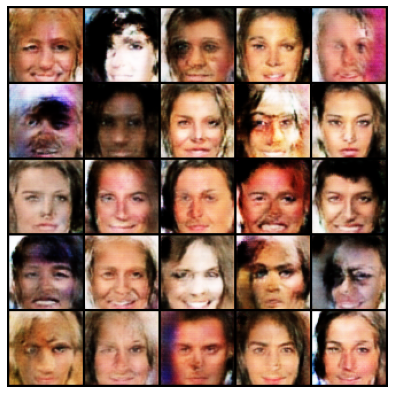

In [34]:
random_input = generate_noise(100, latent_dim)
generated_images = generator(random_input)
show_images(generated_images, num_images=25, size=(7, 7))
save_image(generated_images[:25], IMG_DIR_PATH + '/random_generation.png', nrow=5, normalize=True)

Another amazing stuff we can do with GANs is to see how the Generator's outputs change moving from one point in the latent space to another one. In this case we will linearly interpolate between $5$ images to other $5$ images. Let's start generating the $5$ starting point images and the $5$ final points images.

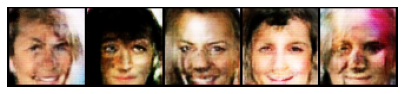

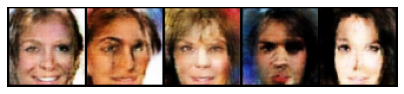

In [53]:
# Start images
start_noise = generate_noise(5, latent_dim)
start_images = generator(start_noise)
# Final images
final_noise = generate_noise(5, latent_dim)
final_images = generator(final_noise)

show_images(start_images, num_images=5, size=(7, 7))
show_images(final_images, num_images=5, size=(7, 7))

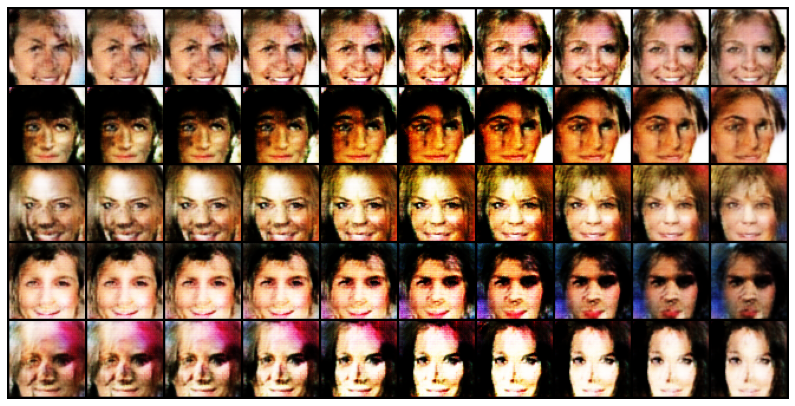

In [54]:
alphas = np.linspace(0, 1, 10)
interp_images = None
for alpha in alphas:
    random_input_interp = (1 - alpha) * start_noise + alpha * final_noise
    generated_images_interp = generator(random_input_interp)
    generated_images_interp = torch.transpose(generated_images_interp[None, :],0,1)
    interp_images = generated_images_interp if interp_images is None else torch.cat((interp_images, generated_images_interp), 1)
interp_images = torch.reshape(interp_images, (interp_images.shape[0]*interp_images.shape[1], 3, 64, 64))
show_images(interp_images, num_images=50, size=(14, 14), n_row=10)
save_image(interp_images.data[:50], IMG_DIR_PATH + '/interpolation.png', nrow=10, normalize=True)

The first column contains the starting images and the last one the final images. You can see that by moving inside the latent space step by step the initial images start morphing into the final ones!!

## Save and Load Models
Let's finish this notebook with two really important steps: how to save the weights and how to load a pretrained model.

In [27]:
# Save generator and discriminator
torch.save(generator.state_dict(), WEIGHTS_DIR_PATH + '/generator')
torch.save(discriminator.state_dict(), WEIGHTS_DIR_PATH + '/discriminator')

Instantiate both the generator and the discriminator from scratch:

In [28]:
generator_loaded = Generator(latent_dim=latent_dim, channels=channels_g,
                      kernel_size=kernel_size, stride=stride,
                      padding=padding).to(device)
discriminator_loaded = Discriminator(channels=channels_d, kernel_size=kernel_size,
                              stride=stride, padding=padding).to(device)

Test the model before loading weights:

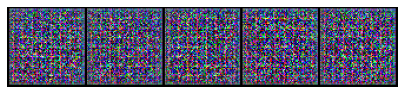

In [29]:
noise = generate_noise(5, latent_dim)
images_pre_loading = generator_loaded(noise)

show_images(images_pre_loading, num_images=5, size=(7, 7))

In [30]:
# Load the weights
generator_loaded.load_state_dict(torch.load(WEIGHTS_DIR_PATH + '/generator'))
discriminator_loaded.load_state_dict(torch.load(WEIGHTS_DIR_PATH + '/discriminator'))

<All keys matched successfully>

Test the model after loading the weights:

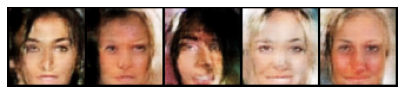

In [31]:
noise = generate_noise(5, latent_dim)
images_after_loading = generator_loaded(noise)

show_images(images_after_loading, num_images=5, size=(7, 7))

<span style='font-family:Helvetica;font-size:20pt;color:DarkCyan;font-weight:bold'>References:</span>
1. [Build Basic Generative Adversarial Network (Coursera)](https://www.coursera.org/learn/build-basic-generative-adversarial-networks-gans)
2. ["Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks" (2016)](https://arxiv.org/abs/1511.06434)
3. https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
4. https://github.com/gordicaleksa/pytorch-gans
5. https://www.youtube.com/watch?v=yz6dNf7X7SA&t=17s
6. https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215